In [1]:
import yfinance as yf
import statsmodels 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import nasdaqdatalink as ndl
plt.style.use('seaborn-darkgrid')
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45675/3347480493.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
ticker = 'SPY'
spy = yf.download(ticker, start = '2014-01-01' , end ='2019-12-31')
spy = pd.DataFrame(spy)
spy['Return'] = spy['Adj Close'].pct_change()
effr = ndl.get("FRED/DFF", start_date = '2014-01-01' , end_date ='2019-12-31')

spy['Excess Return'] = spy['Return'] - (effr['Value']/(100*252))
spy['Daily interest rate'] = effr['Value']/(100*252)

[*********************100%***********************]  1 of 1 completed


In [3]:



def window(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)


seq_length = 7
data_dim = 1
hidden_dim = 32
output_dim = 1
learning_rate = 0.01
epochs = 500

 
xy = spy['Adj Close'].values.reshape(-1,1)


scaler = MinMaxScaler()
xy = scaler.fit_transform(xy)
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

 
trainX, trainY = window(train_set, seq_length)
testX, testY = window(test_set, seq_length)

 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)


trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

In [8]:
class SpyPrediction(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(SpyPrediction, self).__init__()
        
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [9]:
model = SpyPrediction(data_dim, hidden_dim, output_dim, 1).to(device)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = np.zeros(epochs)

In [10]:
#training loop
for i in range(500):
    
    optimizer.zero_grad()
    
    outputs = model(trainX_tensor)
    
    loss = criterion(outputs, trainY_tensor)
    
    loss.backward()
    
    optimizer.step()
    
    if (i+1) % 50 == 0:
        print(f'epoch {i}, training loss : {loss.item()}')

epoch 49, training loss : 0.0006001308793202043
epoch 99, training loss : 0.00016923839575611055
epoch 149, training loss : 0.0001615748624317348
epoch 199, training loss : 0.00015855948731768876
epoch 249, training loss : 0.00015533366240561008
epoch 299, training loss : 0.0001519335783086717
epoch 349, training loss : 0.00014840016956441104
epoch 399, training loss : 0.0001447646936867386
epoch 449, training loss : 0.0001410539698554203
epoch 499, training loss : 0.00013729336205869913


In [11]:
pred_train = model(trainX_tensor).cpu().detach().numpy()

pred_test = model(testX_tensor).cpu().detach().numpy()

spy['Train Predictions'] = None
spy['Train Predictions'][:len(pred_train)] = scaler.inverse_transform(pred_train).flatten()
spy['Test Predictions'] = None
spy['Test Predictions'][-len(pred_test):] = scaler.inverse_transform(pred_test).flatten()


#plotting training and data
#plt.figure(figsize=(12, 9))


/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45675/2017588892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['Train Predictions'][:len(pred_train)] = scaler.inverse_transform(pred_train).flatten()
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_45675/2017588892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['Test Predictions'][-len(pred_test):] = scaler.inverse_transform(pred_test).flatten()


In [12]:
spy_train = spy[:len(train_set)]
spy_test = spy[len(train_set):]

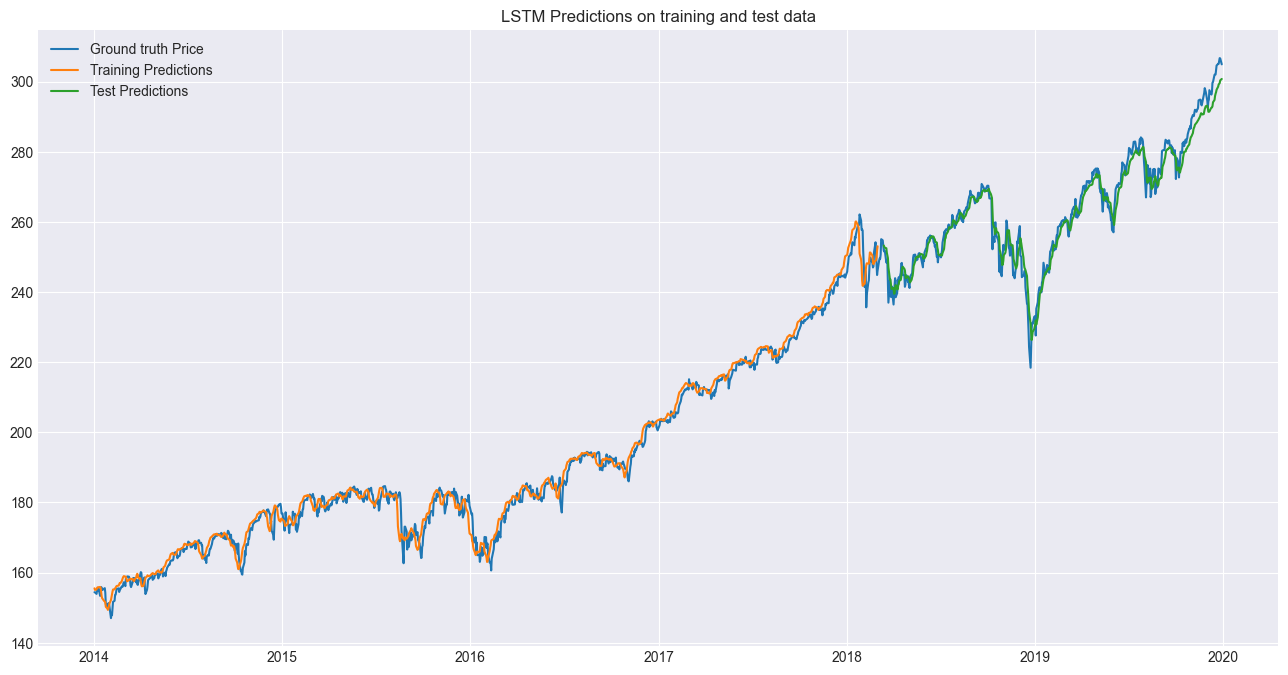

In [13]:
plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('LSTM Predictions on training and test data')
plt.plot(spy['Adj Close'], label='Ground truth Price')
plt.plot(spy['Train Predictions'], label='Training Predictions')
plt.plot(spy['Test Predictions'], label='Test Predictions')
plt.legend()

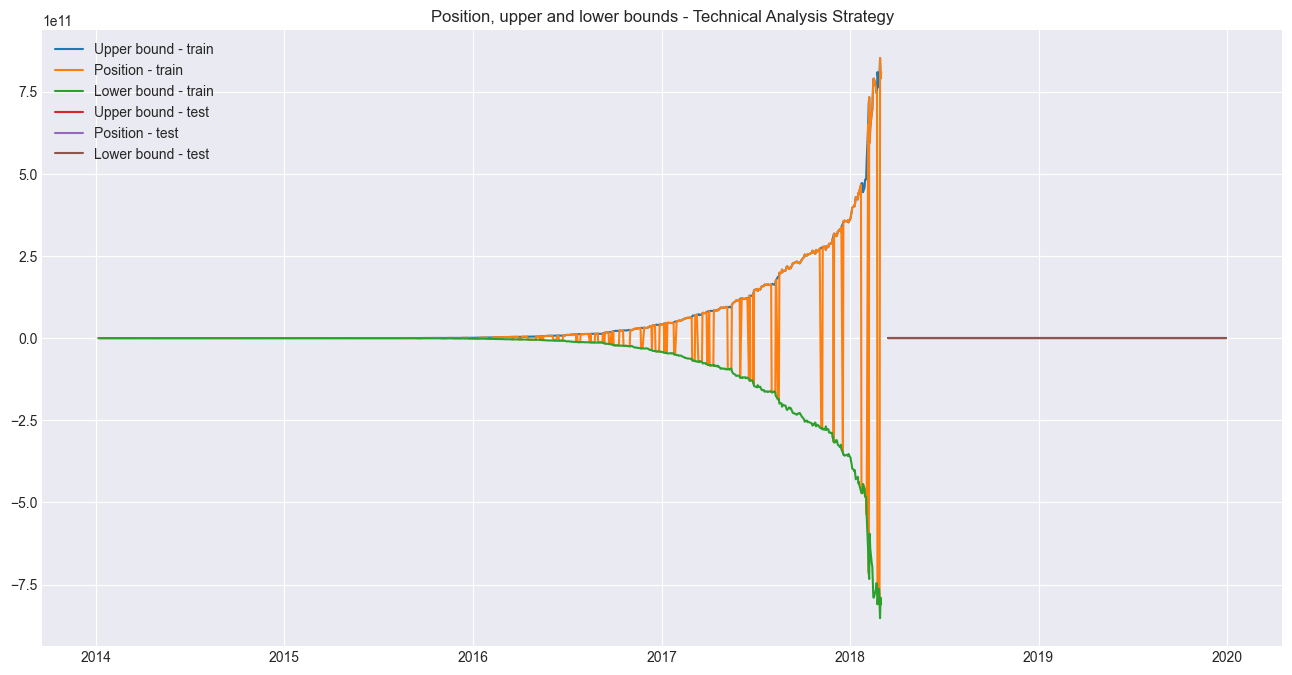

In [14]:
spy_train = spy_train.dropna(subset = ['Adj Close', 'Train Predictions'])
spy_test = spy_test.dropna(subset = ['Adj Close', 'Test Predictions'])

def LSTM_strategy_train(df, leverage, initial_cap):
    df['Signal'] = np.where(df['Train Predictions'] >= df['Adj Close'], leverage, -leverage)
    df['Signal'] = np.where(df['Signal'].isnull(), 0, df['Signal'])
    df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
    df['Cash'] = (1+df['Strategy Return']).cumprod() * initial_cap
    df['PnL'] = df['Cash'].diff()
    return df

def LSTM_strategy_test(df, leverage, initial_cap):
    df['Signal'] = np.where(df['Test Predictions'] >= df['Adj Close'], leverage, -leverage)
    df['Signal'] = np.where(df['Signal'].isnull(), 0, df['Signal'])
    df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
    df['Cash'] = (1+df['Strategy Return']).cumprod() * initial_cap
    df['PnL'] = df['Cash'].diff()
    return df

spy_train = LSTM_strategy_train(spy_train, 5, 200000)
spy_test = LSTM_strategy_test(spy_test, 5, 200000)

spy_train = spy_train.dropna(subset = ['Adj Close', 'Train Predictions', 'Cash', 'Signal', 'Strategy Return', 'PnL'])
spy_test = spy_test.dropna(subset = ['Adj Close', 'Test Predictions', 'Cash', 'Signal', 'Strategy Return', 'PnL'])

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Position, upper and lower bounds - Technical Analysis Strategy')
plt.plot(spy_train['Cash']*5, label= 'Upper bound - train')
plt.plot(spy_train['Cash']*spy_train['Signal'], label= 'Position - train')
plt.plot(spy_train['Cash']*-5, label= 'Lower bound - train')
plt.plot(spy_test['Cash']*5, label  = 'Upper bound - test')
plt.plot(spy_test['Cash']*spy_test['Signal'], label= 'Position - test')
plt.plot(spy_test['Cash']*-5, label= 'Lower bound - test')
plt.legend(loc='upper left')

In [15]:
def turnover(spy):
    turnover_cash = (spy['Cash']*spy['Signal']).diff().abs().sum()
    turnover_units = ((((spy['Cash']*spy['Signal'])/spy['Adj Close']))
                    -((spy['Cash']*spy['Signal'].shift(1)/spy['Adj Close'].shift(1)))).abs().sum()

    print(turnover_cash, turnover_units)

turnover(spy_train)
turnover(spy_test)

20126406374972.21 83982015593.89543
138073311.55976754 529725.0769803493


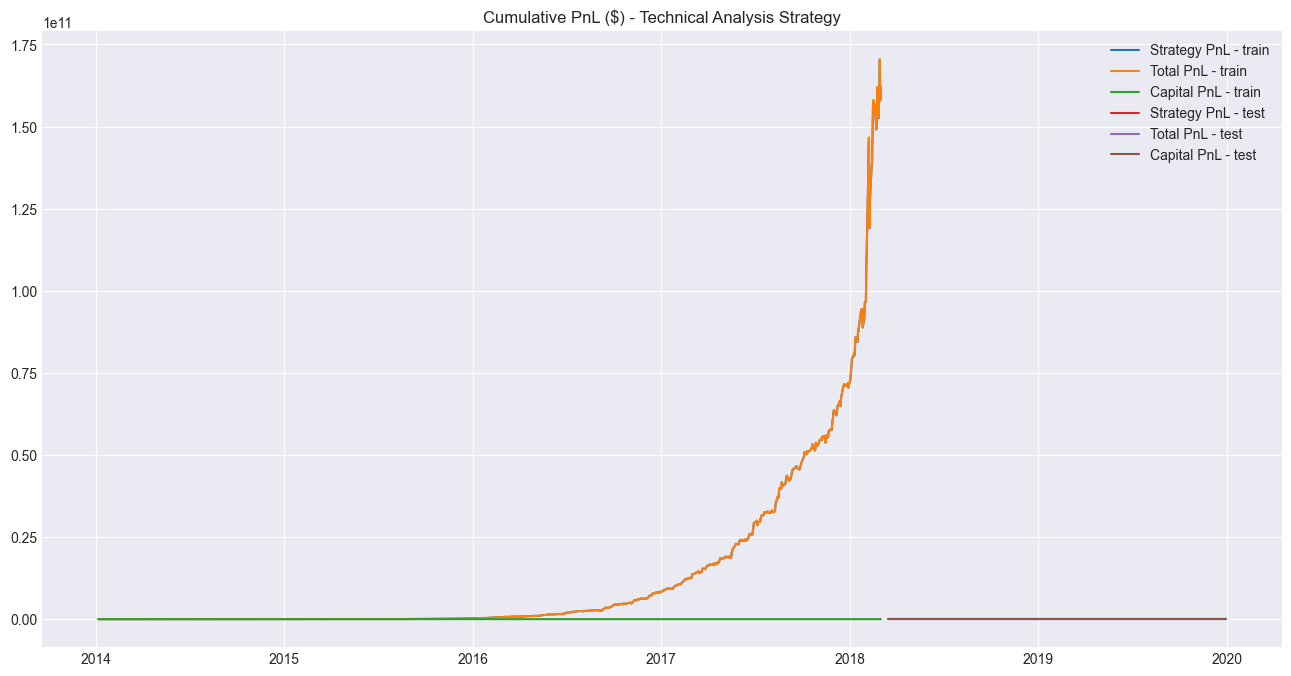

In [16]:
def total_pnl(df, initial_cap):
    df['Total strategy return'] = np.where(df['Signal'].shift(1) == 0, df['Daily interest rate'], df['Strategy Return'])
    df['Total strategy cash'] = (1+df['Total strategy return']).cumprod() * initial_cap
    df['Total PnL'] = df['Total strategy cash'].diff()
    return df

spy_train = total_pnl(spy_train, 200000)
spy_test = total_pnl(spy_test, 200000)

spy_train['Capital PnL'] = np.where(spy_train['Signal'].shift(1) == 0, spy_train['Total PnL'], 0)
spy_test['Capital PnL'] = np.where(spy_test['Signal'].shift(1) == 0, spy_test['Total PnL'], 0)

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Cumulative PnL ($) - Technical Analysis Strategy')
plt.plot(spy_train['PnL'].cumsum(), label = 'Strategy PnL - train')
plt.plot(spy_train['Total PnL'].cumsum(), label = 'Total PnL - train')
plt.plot(spy_train['Capital PnL'].cumsum(), label = 'Capital PnL - train')
plt.plot(spy_test['PnL'].cumsum(), label = 'Strategy PnL - test')
plt.plot(spy_test['Total PnL'].cumsum(), label = 'Total PnL - test')
plt.plot(spy_test['Capital PnL'].cumsum(), label = 'Capital PnL - test')
plt.legend()



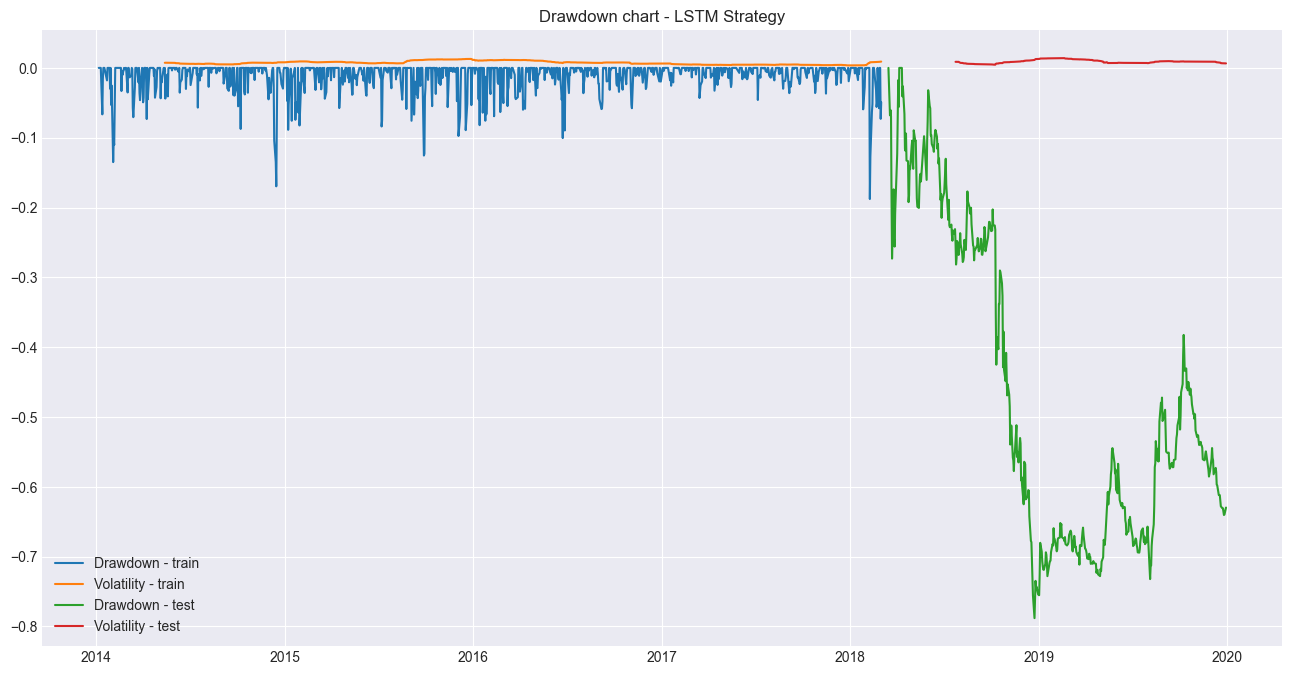

In [17]:
plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Drawdown chart - LSTM Strategy')
plt.plot(-(spy_train['Cash'].cummax() - spy_train['Cash'])/spy_train['Cash'].cummax(), label = 'Drawdown - train')
plt.plot(spy_train['Return'].rolling(90).std(), label = 'Volatility - train')
plt.plot(-(spy_test['Cash'].cummax() - spy_test['Cash'])/spy_test['Cash'].cummax(), label = 'Drawdown - test')
plt.plot(spy_test['Return'].rolling(90).std(), label = 'Volatility - test')
plt.legend()

In [18]:
# compute the Sharpe ratio

def annualised_sharpe_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'].std()*np.sqrt(252))

print(annualised_sharpe_ratio(spy_train))
print(annualised_sharpe_ratio(spy_test))

# compute the sortino ratio

def annualised_sortino_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'][df['Strategy Return']<0].std()*np.sqrt(252))

print(annualised_sortino_ratio(spy_train))
print(annualised_sortino_ratio(spy_test))

# compute the max drawdown

def max_drawdown(df):
    comp_ret = (df['Strategy Return']+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

print(max_drawdown(spy_train))
print(max_drawdown(spy_test))
# compute the calmar ratio

def calmar_ratio(df):
    return (df['Strategy Return'].mean()*252)/abs(max_drawdown(df))

print(calmar_ratio(spy_train))
print(calmar_ratio(spy_test))

5.929174447521566
-0.26735858234831444
9.46676394536854
-0.40669554655037304
-0.1878259117779617
-0.7881925562213176
18.43448883010112
-0.24604333747958024


In [19]:
print(spy_test['Strategy Return'].mean(), spy_test['Strategy Return'].std())

-0.0007695616155129153 0.045692985846304913
